In [1]:
import os
#from google.colab import drive

# Mount Google Drive at /gdrive
#drive.mount('/gdrive')

# Change the current working directory to the specified path
#os.chdir('/gdrive/My Drive/[2024-2025] AN2DL/Homework 1')
print(os.getcwd())

/kaggle/working


In [2]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow import keras as tfk
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.utils import shuffle
import keras_cv

import datetime
import cv2

import random

import seaborn as sns
import matplotlib.pyplot as plt

print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

# mixed_precision.set_global_policy('mixed_float16')

Tensorflow version -> 2.16.1
Keras version -> 3.3.3


In [3]:
## On Kaggle
data = np.load('/kaggle/input/training-set/training_set.npz')
# data = np.load('/kaggle/input/cellule/training_set.npz')
## On Colab
# data = np.load('training_set.npz')

X = data['images']
Y = data['labels']

In [4]:
def plot_sample_images(X, Y, num_samples=8, col = 3):
    """
    Plot sample images from the dataset
    :param X: images
    :param Y: labels
    :param num_samples: number of samples to plot
    :param col: number of columns to plot
    """
    plt.figure(figsize=(15, 10))
    for i in range(num_samples*col):
        plt.subplot(col, num_samples, i + 1)
        plt.imshow(X[-i])
        plt.title(f'Label: {Y[-i]}')
        plt.axis('off')
    plt.show()


[[   0 1052]
 [   1 2381]
 [   2 1285]
 [   3 2226]
 [   4 1049]
 [   5 1393]
 [   6 2530]
 [   7 1843]]
Shape before removing meme images: (13759, 96, 96, 3)
Shape after removing meme images: (11959, 96, 96, 3)


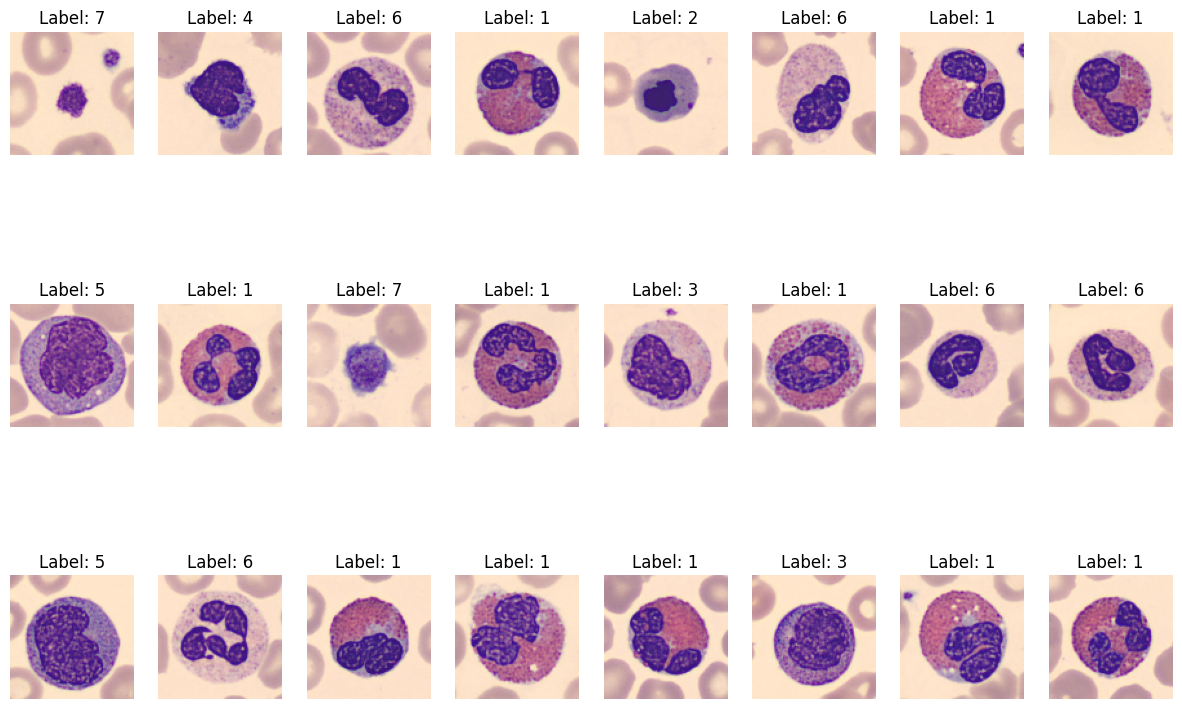

In [5]:
# Check if the dataset is balanced
unique, counts = np.unique(Y, return_counts=True)
print(np.asarray((unique, counts)).T)

# Remove meme images
print(f"Shape before removing meme images: {X.shape}")
meme_indices = range(11959, X.shape[0])
X = np.delete(X, meme_indices, axis=0)
Y = np.delete(Y, meme_indices, axis=0)
print(f"Shape after removing meme images: {X.shape}")

# Plot sample images from the training set
plot_sample_images(X, Y.flatten())

del unique, counts, meme_indices

In [6]:
X_train, val_X, y_train, val_Y = train_test_split(X, Y, random_state=seed, test_size=0.30, stratify=np.argmax(Y, axis=1))
X_test, val_X, y_test, val_Y = train_test_split(val_X, val_Y, random_state=seed, test_size=0.40, stratify=np.argmax(val_Y, axis=1))
del data, X, Y

In [7]:
def balance_dataset_with_blending(data, labels, number_img_per_class = None, verbose = 0):
    """
    Balance the dataset by blending images of underrepresented classes
    :param data: images
    :param labels: labels
    :param number_img_per_class: number of images per class
    :param verbose: verbosity level <-> 0: no print, 1: print some images
    :return: balanced dataset
    """

    # Find the maximum class size
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f"Number of classes: {len(unique)}")
    print(f"Number of images per class: {class_counts}")
    max_class_size = 0
    if number_img_per_class is None:
        max_class_size = max(class_counts.values())
    else:
        max_class_size = number_img_per_class
    print(f"Maximum class size: {max_class_size}")

    # Initialize new dataset lists
    X_balanced = []
    Y_balanced = []

    # Loop over each class to balance
    for class_label in unique:
        # Filter images of the current class
        class_indices = np.where(labels == class_label)[0]
        class_images = data[class_indices]

        # Add original images of the class to the balanced dataset
        X_balanced.extend(class_images)
        Y_balanced.extend([class_label] * len(class_images))

        # Calculate how many more images are needed to reach max_class_size
        num_images_needed = max_class_size - len(class_images)
                # Generate blended images if the class is underrepresented
        while num_images_needed > 0:
            # Randomly pick two images to blend
            img1, img2 = random.choices(class_images, k=2)

            # Blend images with 50-50 ratio (you can vary this ratio)
            alpha = 0.2
            blended_img = cv2.addWeighted(img1, alpha, img2, 1 - alpha, 0)

            # Append the blended image to the dataset
            X_balanced.append(blended_img)
            Y_balanced.append(class_label)

            num_images_needed -= 1

    # Convert lists back to numpy arrays
    X_balanced = np.array(X_balanced)
    Y_balanced = np.array(Y_balanced)

    return X_balanced, Y_balanced

In [8]:
def CustomRandAugment(x, num_augmentations = 2, geometrical=False):
    if geometrical:
        maxIndex=9
    else:
        maxIndex=7
        
    # Check value range 
    value_range=(np.min(x), np.max(x))

    x=tfkl.RandomFlip("horizontal_and_vertical")(x)
    x=tfkl.RandomRotation(1, value_range=value_range)(x) # 1 set it all 360°, value range is of the pixels
    x=tfkl.RandomBrightness(0.3)(x)       
    x=tfkl.RandomContrast(0.3)(x)
    
    for N in range(1,num_augmentations):
        i=np.random.randint(maxIndex)
        match i:
            case 1:
                x=keras_cv.layers.AutoContrast([0, 255])(x)
            case 2:
                x=keras_cv.layers.RandomHue((0.4, 0.4),[np.min(value_range), np.max(value_range)])(x)
            case 3:
                x=keras_cv.layers.ChannelShuffle(groups=3)(x)
            case 4:
                x=keras_cv.layers.GridMask(ratio_factor=(0, 0.4),rotation_factor=0.15)(x) #non mi convince (mette dei quadrati neri sulla foto)
            case 5:
                x=keras_cv.layers.RandomChannelShift(value_range=value_range,factor=0.5)(x)
            case 6:
                x=keras_cv.layers.RandomColorDegeneration(factor=0.8)(x)
            case 7:
                x=keras_cv.layers.RandomCutout(height_factor=(0.1, 0.2), width_factor=(0.1, 0.2), fill_mode="gaussian_noise")(x)
            case 8:
                x=keras_cv.layers.RandomSaturation(factor=0.8)(x)
            case 9:
                x=keras_cv.layers.Solarization(value_range=value_range,threshold_factor=100)(x)
            case 10:
                x=keras_cv.layers.Equalization(value_range=value_range, bins=255)(x)
            case 11:
                x=keras_cv.layers.JitteredResize(target_size=(96,96),scale_factor=(0.2,0.9))(x)
            case 12:
                x=keras_cv.layers.RandomShear(x_factor=0.3,y_factor=0.3,interpolation="bilinear",fill_mode="reflect",fill_value=0.0,bounding_box_format=None)(x)
            case 13:
                x=tfkl.RandomTranslation(height_factor=0.3,width_factor=0.2)(x)
            case 14:
                x=tfkl.RandomZoom(height_factor=0.2,width_factor=0.2)(x)
    return x
    

def augment_img(img, augmentation):
    """
    Augment a single image using the specified augmentation pipeline.
    :param img: image to augment
    :param augmentation: augmentation pipeline
    :return: augmented image with values clipped between 0 and 1
    """
    augmented_img = CustomRandAugment(x=img, geometrical=False)
    # augmented_img = augmentation(img)
    return  augmented_img.numpy().astype(np.float32)

def augment_data(data, labels, augmentation,  number_img = 1000):
    """
    Augment a dataset using the specified augmentation pipeline and return the augmented data concatenated with the original data.
    :param data: images
    :param labels: labels
    :param augmentation: augmentation pipeline
    :param number_img: number of desired images per classes
    """
    image_to_generate = max(number_img - len(data), 0)
    
    # Pre-calculate indices for sampling
    indices = np.random.randint(0, len(data), size=image_to_generate)
    
    # Initialize arrays for augmented data
    data_augmented = np.zeros((image_to_generate, *data.shape[1:]), dtype=data.dtype)
    labels_augmented = np.zeros((image_to_generate, *labels.shape[1:]), dtype=labels.dtype)

    # Apply augmentation in batches for efficiency
    batch_size = 64
    for i in range(0, image_to_generate, batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_images = data[batch_indices]
        
        print(f"\rUpdate the class percentage {100*i/image_to_generate} %", end = "")
        
        # Apply augmentation to the batch
        augmented_batch = np.array([
            augment_img(img, augmentation) for img in batch_images
        ])
        
        # Store the augmented batch
        data_augmented[i:i+len(batch_indices)] = augmented_batch
        labels_augmented[i:i+len(batch_indices)] = labels[batch_indices]

    return np.concatenate((data, data_augmented), axis=0), np.concatenate((labels, labels_augmented), axis=0)

def class_balancing(data, labels, augmentation, number_img_per_class = 10, verbose = 0):
    """
    Function to balance class distribution in the training data with augmentation.
    :param data: images
    :param labels: labels
    :param augmentation: augmentation pipeline
    :param number_img_per_class: number of images per class
    :param verbose: verbosity level <-> 0: no print, 1: print some images
    :return: balanced dataset
    """

    # Count the number of images per class
    unique_classes, counts = np.unique(labels, return_counts=True)
    print(f"Number of classes: {len(unique_classes)}")
    print(f"Number of images per class: {counts}")
    number_aug = np.maximum(number_img_per_class - counts, 0)
    print(f"Number of augmented images per class: {number_aug}\n")

    # Preallocate memory for the balanced dataset
    data_balanced = np.zeros((number_img_per_class * len(unique_classes), *data.shape[1:]), dtype=data.dtype)
    labels_balanced = np.zeros((number_img_per_class * len(unique_classes), *labels.shape[1:]), dtype=labels.dtype)

    for i, c in enumerate(unique_classes):
        # Filter images of the current class
        print(f"Augmenting class {c}")
        class_indices = np.where(labels == c)[0]
        class_data = data[class_indices]
        class_labels = labels[class_indices]

        # Augment the data
        augmented_data, augmented_labels = augment_data(class_data, class_labels, augmentation, number_img_per_class)

        # Display some augmented images if verbose
        if verbose:
            plot_sample_images(augmented_data, augmented_labels)

        # Add the augmented data to the balanced dataset
        start = i * number_img_per_class
        end = (i + 1) * number_img_per_class
        data_balanced[start:end] = augmented_data
        labels_balanced[start:end] = augmented_labels

    return data_balanced, labels_balanced


def display_class_distribution(xxxx, title="Class Distribution"):
    """
    Display the distribution of classes in a dataset.
    :param xxxx: labels
    :param title: plot title
    """
    print(f"{title}:")
    unique, counts = np.unique(xxxx, return_counts=True)
    print(np.asarray((unique, counts)).T)

In [9]:
def augmentation_pipeline(X_train, y_train, balanced = True, random_augmentation = False, number = 3000, verbose = 0):
    """
    Function to create the augmentation pipeline.
    :param X_train: images
    :param y_train: labels
    :param balanced: boolean to balance the dataset with blending
    :param random_augmentation: boolean to augment the dataset with random tecniques
    :param number: number of images per class
        :param verbose: verbosity level <-> 0: no print, 1: print some images after every step
    :return: augmented dataset with images concatenated with the original images and clipped between 0 and 1
    """
    if balanced :
        # Balance the dataset
        if not random_augmentation:
            X_balanced, Y_balanced = balance_dataset_with_blending(X_train, y_train.flatten(), number_img_per_class = number)
        else:
            X_balanced, Y_balanced = balance_dataset_with_blending(X_train, y_train.flatten())

        # Add a channel dimension
        Y_balanced= np.expand_dims(Y_balanced, axis = 1)

        # Verify new class distribution
        unique_balanced, counts_balanced = np.unique(Y_balanced, return_counts=True)
        print("Balanced Class Distribution:", np.asarray((unique_balanced, counts_balanced)).T)

        # Plot sample images from the balanced dataset
        if verbose:
            plot_sample_images(X_balanced, Y_balanced)

        # Save the balanced dataset
        X_train, y_train = X_balanced, Y_balanced

        del X_balanced, Y_balanced

    if random_augmentation:
        """
        augmentation = tfk.Sequential([
            tfkl.RandomFlip("horizontal_and_vertical"),
            tfkl.RandomRotation(1), # 1 set it all 360°, value range is of the pixels
            tfkl.RandomBrightness(0.5, value_range=(0,1)),
            tfkl.RandomContrast(0.8),
            
        ], name='Augmentation')
        """
        augmentation=tfk.Sequential([
            keras_cv.layers.RandAugment(value_range=(0,255),augmentations_per_image=3,magnitude=0.5,magnitude_stddev=0.15,rate=0.9090909090909091,geometric=False),
            keras_cv.layers.AugMix(value_range=(0,255),severity=0.3,num_chains=3,chain_depth=[1, 3],alpha=1.0)
        ], name='Augment')
        
        # Augment the dataset
        X_augmented, y_augmented = class_balancing(X_train, y_train, augmentation, number, verbose = verbose)
        # Display the class distribution
        display_class_distribution(y_augmented, "Augmented Class Distribution")
        # Save the augmented dataset
        X_train, y_train = X_augmented, y_augmented
        # Normalize the input
        if(np.max(X_train)>1):
            X_train = X_train/255
        del X_augmented, y_augmented

    return X_train, y_train

Number of classes: 8
Number of images per class: [ 585 1537  765 1409  583  705 1638 1149]
Number of augmented images per class: [2415 1463 2235 1591 2417 2295 1362 1851]

Augmenting class 0
Update the class percentage 98.05383022774328 %%

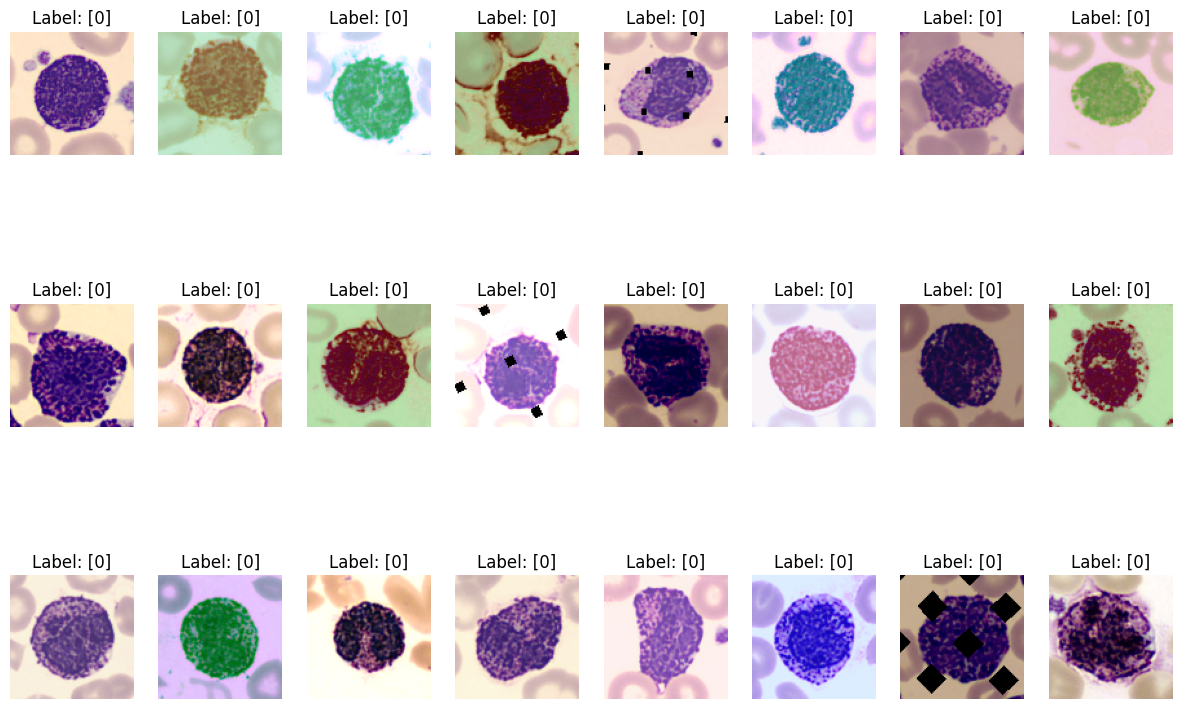

Augmenting class 1
Update the class percentage 96.2406015037594 %%%

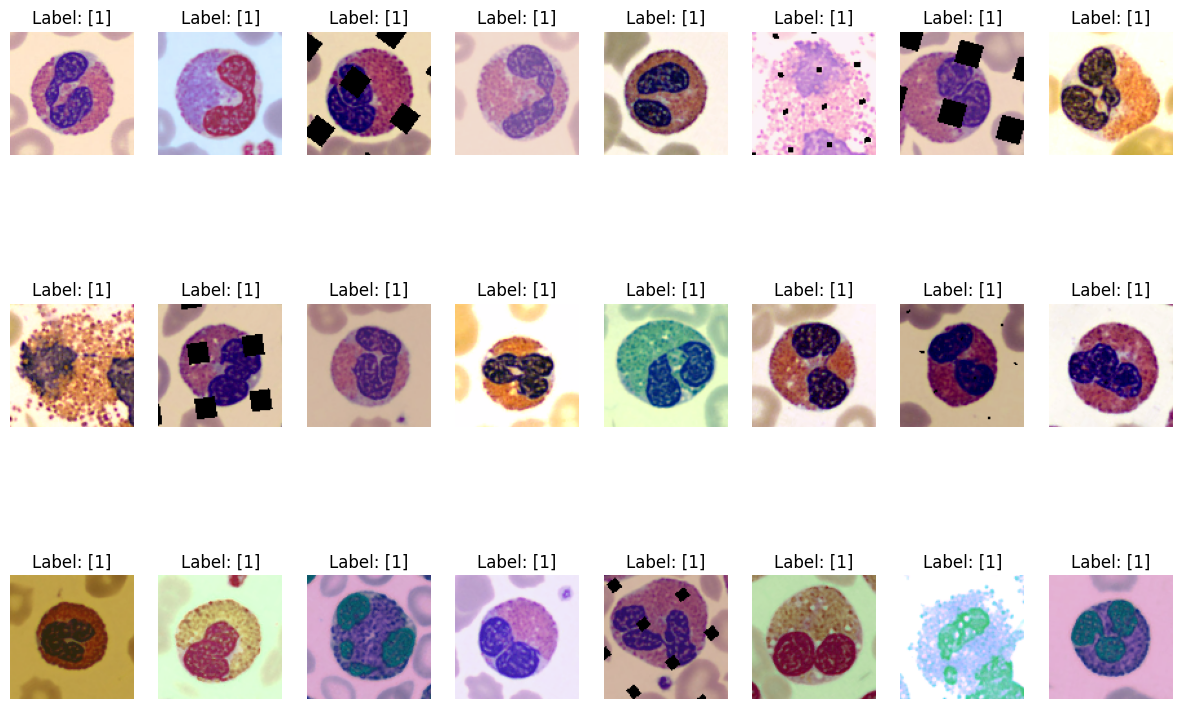

Augmenting class 2
Update the class percentage 97.36017897091723 %%

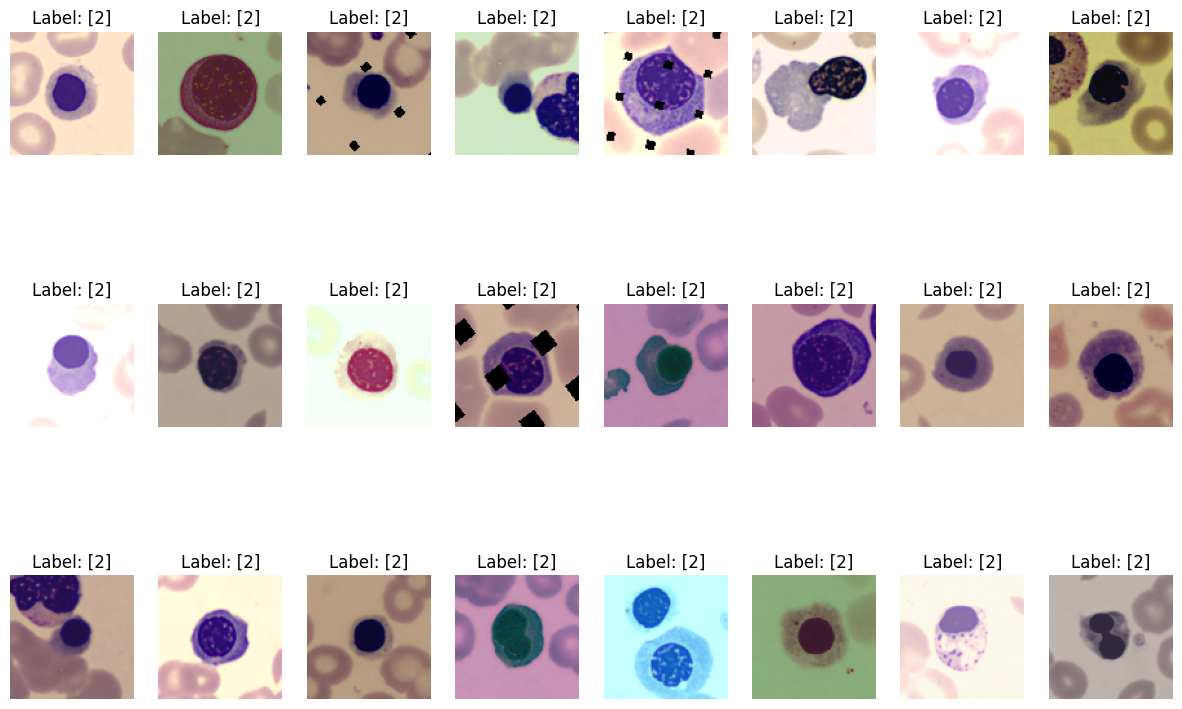

Augmenting class 3
Update the class percentage 96.54305468258957 %%

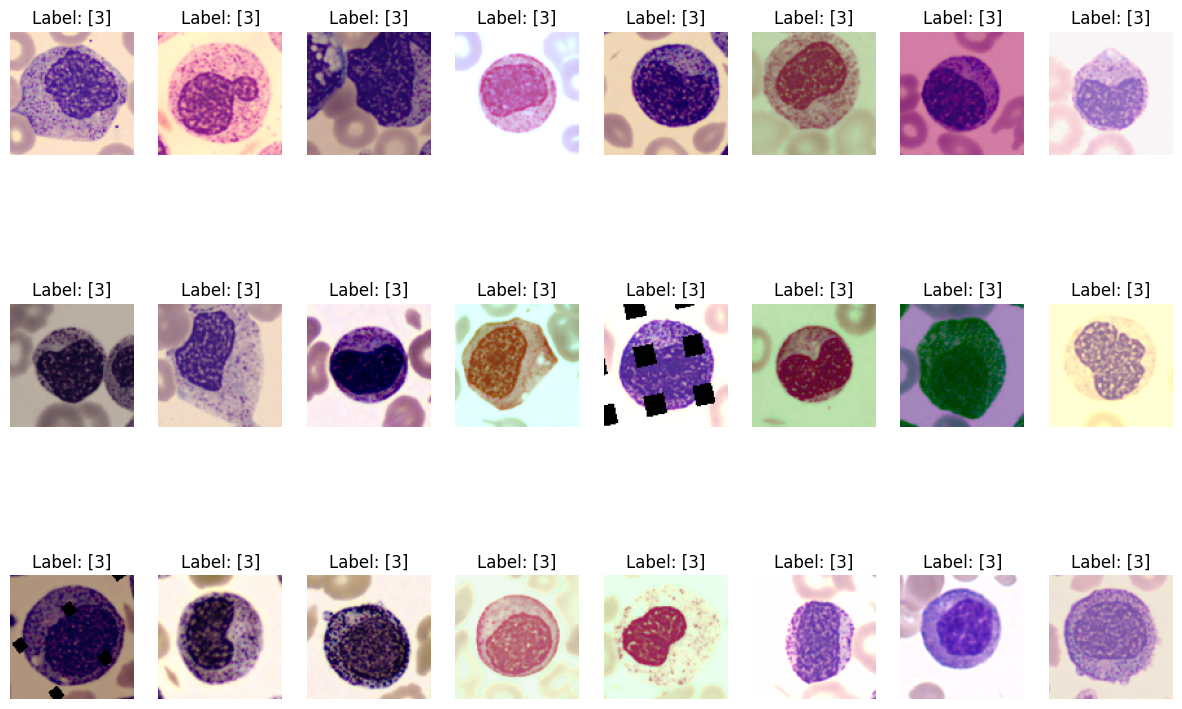

Augmenting class 4
Update the class percentage 97.97269342159701 %%

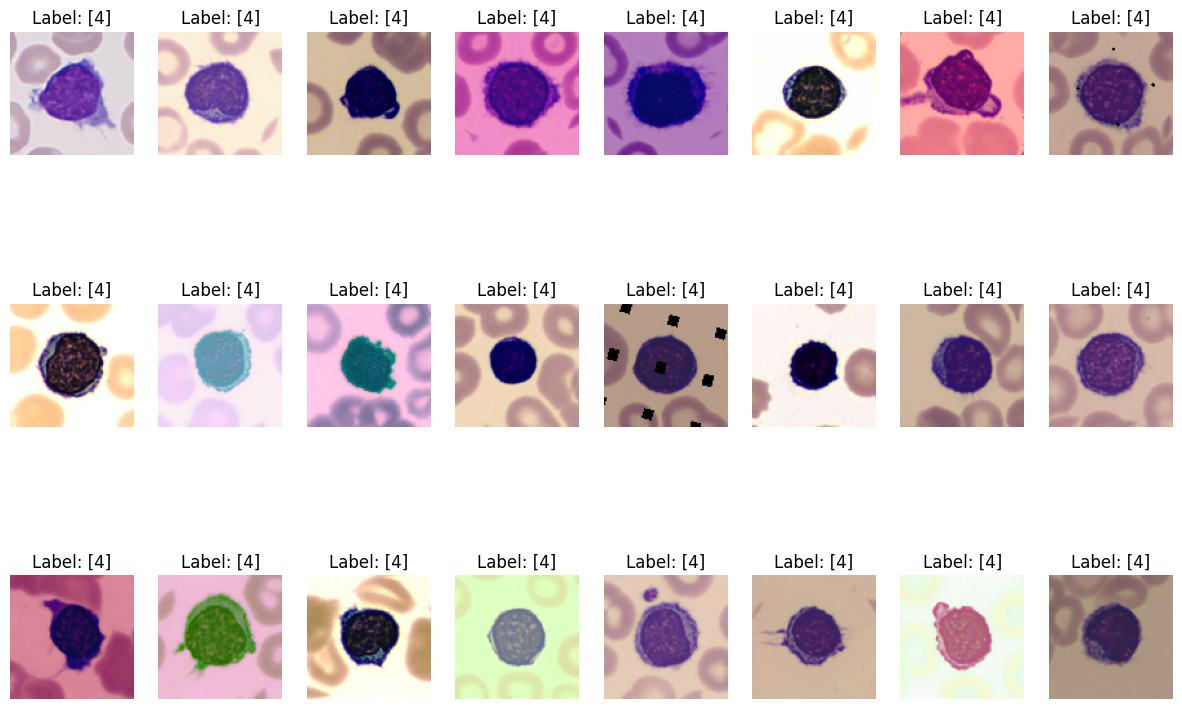

Augmenting class 5
Update the class percentage 97.60348583877996 %%

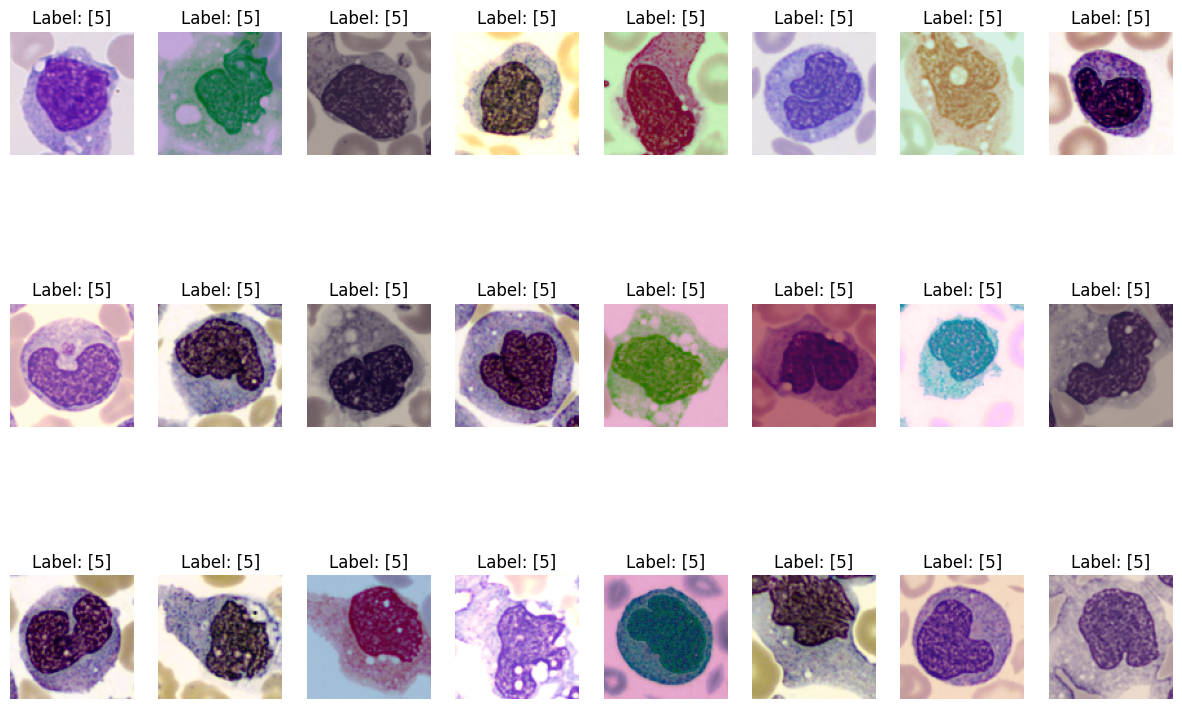

Augmenting class 6
Update the class percentage 98.6784140969163 %%%

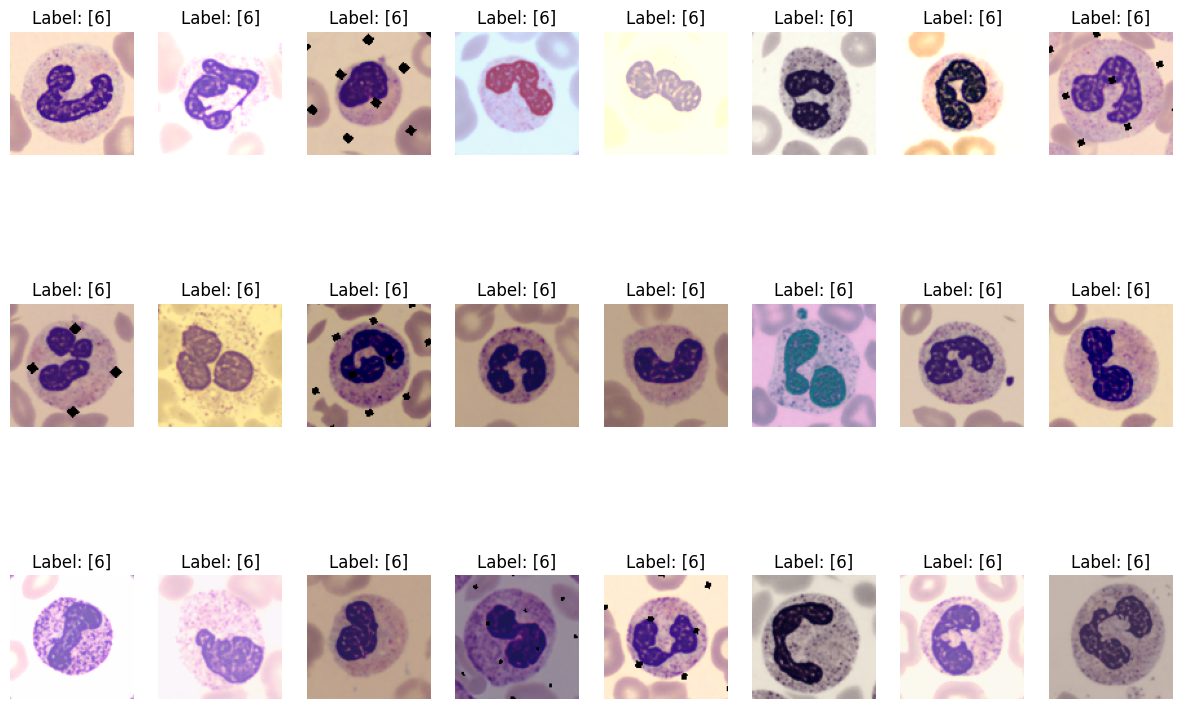

Augmenting class 7
Update the class percentage 96.81253376553215 %%

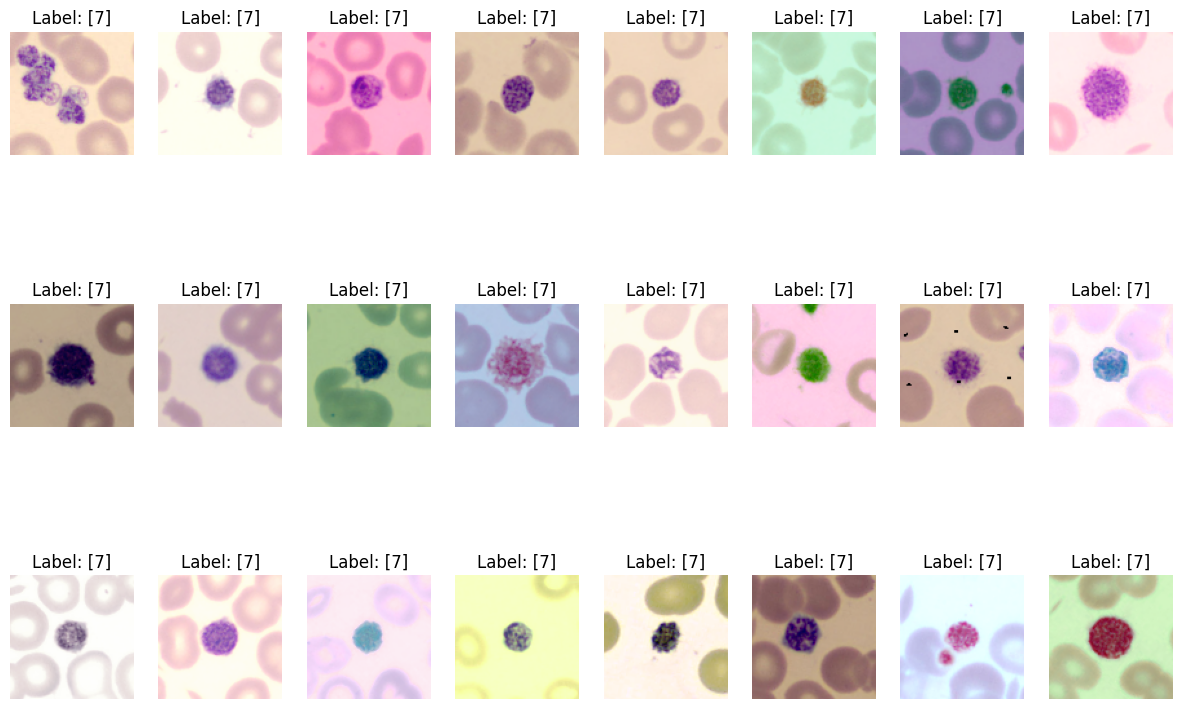

Augmented Class Distribution:
[[   0 3000]
 [   1 3000]
 [   2 3000]
 [   3 3000]
 [   4 3000]
 [   5 3000]
 [   6 3000]
 [   7 3000]]


In [10]:
# Augment the dataset
X_train, y_train = augmentation_pipeline(X_train, y_train, balanced = False, random_augmentation = True, number = 3000, verbose = 1)

In [11]:
import json
import subprocess

# Salva i file come .npy
os.makedirs("train_data", exist_ok=True)  # Crea una cartella per organizzare i file
np.save("train_data/X_train.npy", X_train)
np.save("train_data/y_train.npy", y_train)

# Crea i metadati per il primo dataset (X_train)
metadata_X_train = {
    "title": "X_train Dataset",
    "id": "your_kaggle_username/x-train-dataset",
    "licenses": [{"name": "CC0-1.0"}]
}

# Salva i metadati in un file JSON
with open("train_data/dataset-metadata-x.json", "w") as f:
    json.dump(metadata_X_train, f)

# Crea i metadati per il secondo dataset (y_train)
metadata_y_train = {
    "title": "y_train Dataset",
    "id": "your_kaggle_username/y-train-dataset",
    "licenses": [{"name": "CC0-1.0"}]
}

# Salva i metadati in un file JSON
with open("train_data/dataset-metadata-y.json", "w") as f:
    json.dump(metadata_y_train, f)

# Caricamento su Kaggle
def upload_to_kaggle(dataset_path, metadata_path):
    try:
        subprocess.run(["kaggle", "datasets", "create", "-p", dataset_path, "-u", "-m", metadata_path], check=True)
        print(f"Dataset caricato correttamente da {dataset_path}.")
    except subprocess.CalledProcessError as e:
        print(f"Errore durante il caricamento del dataset: {e}")

# Carica i dataset
upload_to_kaggle("train_data", "train_data/dataset-metadata-x.json")
upload_to_kaggle("train_data", "train_data/dataset-metadata-y.json")

# Specifica i percorsi dei file salvati
x_train_path = "train_data/X_train.npy"
y_train_path = "train_data/y_train.npy"

# Carica i dati dai file .npy
X_train = np.load(x_train_path)
y_train = np.load(y_train_path)

# Controllo dei dati caricati
print(f"Shape di X_train: {X_train.shape}")
print(f"Shape di y_train: {y_train.shape}")

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


Errore durante il caricamento del dataset: Command '['kaggle', 'datasets', 'create', '-p', 'train_data', '-u', '-m', 'train_data/dataset-metadata-x.json']' returned non-zero exit status 1.


Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


Errore durante il caricamento del dataset: Command '['kaggle', 'datasets', 'create', '-p', 'train_data', '-u', '-m', 'train_data/dataset-metadata-y.json']' returned non-zero exit status 1.
Shape di X_train: (24000, 96, 96, 3)
Shape di y_train: (24000, 1)


In [12]:
# One-hot encode the labels of the training
y_train = tfk.utils.to_categorical(y_train)
val_Y = tfk.utils.to_categorical(val_Y)

In [13]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

print(f"input_shape: {input_shape}")
print(f"output_shape: {output_shape}")

input_shape: (96, 96, 3)
output_shape: 8


In [14]:
# Define the patience value for early stopping
patience = 15

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

checkpoint_folder = 'checkpoints'
def setup_checkpoint_folders(start_time, callbacks, checkpoint_folder):
    """
    Function to setup the checkpoint folders and callbacks.
    :param start_time: start time of the training
    :param callbacks: list of callbacks
    :param checkpoint_folder: folder to store the checkpoints
    :return: list of callbacks
    """

    # Add ModelCheckpoint callback for this fold
    if not os.path.exists(checkpoint_folder):
        os.makedirs(checkpoint_folder)

    starting_time_folder = f'{start_time}'
    checkpoint_folder = f'{checkpoint_folder}'
    if not os.path.exists(checkpoint_folder):
        os.makedirs(checkpoint_folder)
    checkpoint_path = f'{checkpoint_folder}/best_model.keras'
    
    checkpoint = tfk.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Add the checkpoint callback to the list of callbacks
    callbacks.append(checkpoint)

    return callbacks

In [15]:
#pretrained_base.summary()

# Initialize EfficientNetB0 model without pretrained weights, for custom training
pretrained_base =  tfk.applications.EfficientNetV2S(
    input_shape=None,
    include_top=False,
    weights='imagenet',
    pooling='avg',
    include_preprocessing=True
)

# Display a summary of the model architecture
pretrained_base.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
# tfk_utils.plot_model(mobilenet, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

# Possible augmentation
augmentation = tfk.Sequential([
            tfkl.RandomFlip("horizontal_and_vertical"),
            tfkl.RandomRotation(1), # 1 set it all 360°, value range is of the pixels
            tfkl.RandomBrightness(0.2, value_range=(0,1)), # invece di 0.1
            tfkl.RandomContrast(0.2), # invece di 0.1
            tfkl.GaussianNoise(0.05)
        ], name='Augmentation')

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetv2-s"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        648 │ rescaling[0][0]   │
│                     │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │         96 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      5,184 │ stem_activation[… │
│ (Conv2D)            │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         96 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_add (Add)   │ (None, None,      │          0 │ block1a_project_… │
│                     │ None, 24)         │            │ stem_activation[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, None,      │      5,184 │ block1a_add[0][0] │
│ (Conv2D)            │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, None,      │         96 │ block1b_project_… │
│ (BatchNormalizatio… │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, None,      │          0 │ block1b_project_… │
│ (Activation)        │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, None,      │          0 │ block1b_project_… │
│ (Dropout)           │ None, 24)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, None,      │          0 │ block1b_drop[0][… │
│                     │ None, 24)         │            │ block1a_add[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │     20,736 │ block1b_add[0][0] │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b

 Total params: 20,331,360 (77.56 MB)

 Trainable params: 20,177,488 (76.97 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [16]:
def create_model(pretrained_model, input_shape=input_shape, output_shape=output_shape, augmentation = augmentation, do_augmentation= False,
                lr=1e-3, fine_tuning=False, freeze_layers=60):
    """
    Function to create a model with the specified pretrained model and input/output shapes.
    :param pretrained_model: pretrained model
    :param input_shape: input shape
    :param output_shape: output shape
    :param augmentation: augmentation pipeline
    :param do_augmentation: boolean to do augmentation at start
    :param lr: Learning rate for transfer learning
    :param fine_tuning: boolean to fine tune the model
    :param freeze_layers: Number of initial layers to freeze

    :return: compiled model
    """

    if fine_tuning:
        # Unfreeze the pretrained model
        pretrained_model.trainable = True

        # Freeze the first `freeze_layers` layers and selectively unfreeze specific types
        for i, layer in enumerate(pretrained_model.layers):
            if i < freeze_layers:  # Freeze the first `freeze_layers`
                layer.trainable = False
            elif isinstance(layer, tfkl.Conv2D) or isinstance(layer, tfkl.DepthwiseConv2D) or isinstance(layer, tfkl.SeparableConv2D):
                layer.trainable = True  # Unfreeze Conv2D and DepthwiseConv2D
            elif isinstance(layer, tfkl.BatchNormalization):
                layer.trainable = False  # Keep BatchNormalization frozen
            else:
                layer.trainable = False  # Freeze other layers (e.g., pooling)
    else:
        pretrained_model.trainable = False

    # Define the input layer with your custom input size
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    # Use tfkl.Resizing to resize input to 299x299 (CHANGE IF DIFFERENT PRETRAINED MODEL!!!)
    x = tfkl.Resizing(height=300, width=300, interpolation="bilinear")(inputs)*255

    # Augmentation
    if do_augmentation:
        x = augmentation(x)
        x = tfkl.BatchNormalization()(x)

    # Pass the upsampled inputs through the Xception base
    x = pretrained_model(x)
    """
    # Apply self-attention
    num_heads = 8
    attention_layer = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=128)
    x = attention_layer(query=x, key=x, value=x)
    """
    # Add dropout for regularization
    x = tfkl.Dropout(0.3, name='dropout')(x)

    # Add a global average pooling layer to reduce spatial dimensions
    # x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    # Add batch normalization before the dense layer
    #x = tfkl.BatchNormalization(name='batch_norm')(x)

    x = tfkl.LayerNormalization(center=True,scale=True)(x)

    # Add a dense layer for final output
    x = tfkl.Dense(output_shape, name='dense', kernel_regularizer=tfk.regularizers.l2(0.02))(x)
    
    # Apply softmax activation for classification
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Define the model
    model = tfk.Model(inputs=inputs, outputs=outputs, name='NASNet_transfer_learning')

    # Compile the model
    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.AdamW(learning_rate = lr), # Lion va a nan
        metrics=['accuracy']
    )

    # Summary of the model
    model.summary(expand_nested=True)

    return model

In [17]:
transfer_learning_model = create_model(
    pretrained_model=pretrained_base,
    input_shape=input_shape,
    output_shape=output_shape,
    augmentation=augmentation,
    do_augmentation=False,
    lr=1e-3,
    fine_tuning=False)


Model: "NASNet_transfer_learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer (InputLayer)   │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ rescaling (Rescaling)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ stem_conv (Conv2D)         │ (None, None, None, 24) │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ stem_bn                    │ (None, None, None, 24) │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ stem_activation            │ (None, None, None, 24) │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_project_conv       │ (None, None, None, 24) │         5,184 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_project_bn         │ (None, None, None, 24) │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_project_activation │ (None, None, None, 24) │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_add (Add)          │ (None, None, None, 24) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1b_project_conv       │ (None, None, None, 24) │         5,184 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1b_project_bn         │ (None, None, None, 24) │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1b_project_activation │ (None, None, None, 24) │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1b_drop (Dropout)     │ (None, None, None, 24) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1b_add (Add)          │ (None, None, None, 24) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block2a_expand_conv        │ (None, None, None, 96) │        20,736 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block2a_expand_bn          │ (None, None, None, 96) │           384 │
│ (BatchNormalization)            │                        │             

 Total params: 20,344,168 (77.61 MB)

 Trainable params: 12,808 (50.03 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [18]:
print(f"Minimum pixel value: {np.min(X_train)}")
print(f"Maximum pixel value: {np.max(X_train)}")
print(f"Type: {X_train.dtype} ")

print(f"shape of train_Y:{y_train.shape}")

Minimum pixel value: 0.0
Maximum pixel value: 1.0
Type: float64 
shape of train_Y:(24000, 8)


In [19]:
print(f"Preprocessing validation set for Xception")
if np.max(val_X) > 1:
    X_val = val_X / 255
else:
    X_val = val_X 
print(f"Minimum pixel value: {np.min(X_val)}")
print(f"Maximum pixel value: {np.max(X_val)}")
print(f"Type: {X_val.dtype} ")

print(f"shape of val_Y:{val_Y.shape}")
print(f"shape of val_X:{X_val.shape}")

Preprocessing validation set for Xception
Minimum pixel value: 0.0
Maximum pixel value: 1.0
Type: float64 
shape of val_Y:(1436, 8)
shape of val_X:(1436, 96, 96, 3)


In [20]:
batch_size = 64
epochs = 70

start_time = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

callbacks = setup_checkpoint_folders(start_time, callbacks, checkpoint_folder)

print(f'Starting training at {start_time}')

# Train the model
pretrained_model_history = transfer_learning_model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, val_Y),
    callbacks=callbacks
).history

Starting training at 2024-11-23_10:51:21
Epoch 1/70


I0000 00:00:1732359107.140344      99 service.cc:145] XLA service 0x5a30b6a8de80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732359107.140397      99 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732359107.140401      99 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732359173.362667      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.5740 - loss: 1.4863
Epoch 1: val_accuracy improved from -inf to 0.91226, saving model to checkpoints/best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 241s 419ms/step - accuracy: 0.5744 - loss: 1.4852 - val_accuracy: 0.9123 - val_loss: 0.4992
Epoch 2/70
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8272 - loss: 0.7289
Epoch 2: val_accuracy improved from 0.91226 to 0.92270, saving model to checkpoints/best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 139s 371ms/step - accuracy: 0.8272 - loss: 0.7289 - val_accuracy: 0.9227 - val_loss: 0.4252
Epoch 3/70
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8396 - loss: 0.6631
Epoch 3: val_accuracy improved from 0.92270 to 0.92618, saving model to checkpoints/best_model.keras
375/375 ━━━━━━━━━━━━━━━━━━━━ 139s 371ms/step - accuracy: 0.8396 - loss: 0.6631 - val_accuracy: 0.9262 - val_loss: 0.4041
Epoch 4/70
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8398 - loss: 0.6

Mean validation accuracy: 0.9321881744596693 std. dev: 0.005316228810295919


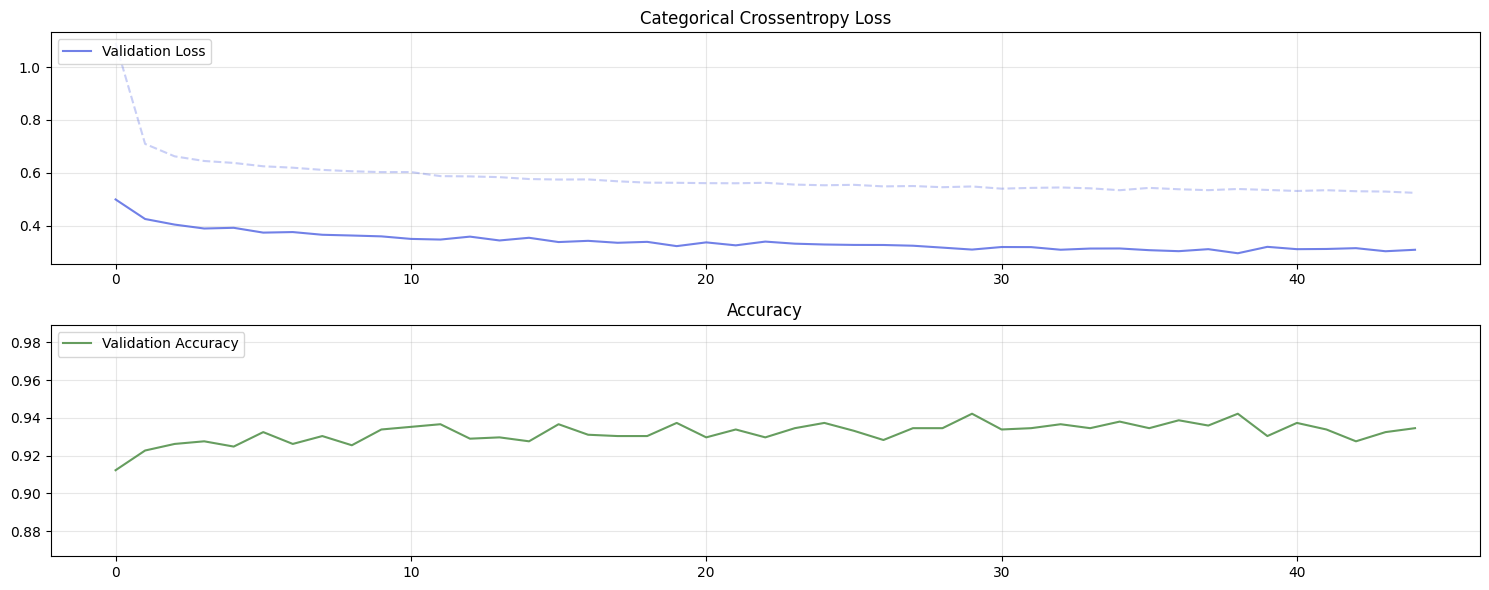

In [21]:
# Mean Validation accuracy and std dev. 
print(f"Mean validation accuracy: {np.mean(pretrained_model_history['val_accuracy'])} std. dev: {np.std(pretrained_model_history['val_accuracy'])}")

# Plotting Training and Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine-Tuning stages
ax1.plot(pretrained_model_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(pretrained_model_history['val_loss'], label='Validation Loss', alpha=0.8, color='#4D61E2')
ax1.set_title('Categorical Crossentropy Loss')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine-Tuning stages
ax2.plot(pretrained_model_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(pretrained_model_history['val_accuracy'], label='Validation Accuracy', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.set_ylim([min(pretrained_model_history['val_accuracy']) * 0.95, max(pretrained_model_history['val_accuracy']) * 1.05])
ax2.legend(loc='upper left')
ax2.grid(alpha=0.3)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [22]:
fine_tune_model = create_model(
    pretrained_model=pretrained_base,
    input_shape=input_shape,  
    output_shape=output_shape,           
    augmentation=augmentation,
    do_augmentation=False,
    lr=1e-4,                   
    fine_tuning=True,
    freeze_layers=350)


# Ensure the weights from the transfer learning phase are used
fine_tune_model.set_weights(transfer_learning_model.get_weights())

Model: "NASNet_transfer_learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_1 (Multiply)           │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer (InputLayer)   │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ rescaling (Rescaling)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ stem_conv (Conv2D)         │ (None, None, None, 24) │           648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ stem_bn                    │ (None, None, None, 24) │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ stem_activation            │ (None, None, None, 24) │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_project_conv       │ (None, None, None, 24) │         5,184 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_project_bn         │ (None, None, None, 24) │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_project_activation │ (None, None, None, 24) │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1a_add (Add)          │ (None, None, None, 24) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1b_project_conv       │ (None, None, None, 24) │         5,184 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1b_project_bn         │ (None, None, None, 24) │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1b_project_activation │ (None, None, None, 24) │             0 │
│ (Activation)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1b_drop (Dropout)     │ (None, None, None, 24) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block1b_add (Add)          │ (None, None, None, 24) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block2a_expand_conv        │ (None, None, None, 96) │        20,736 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block2a_expand_bn          │ (None, None, None, 96) │           384 │
│ (BatchNormalization)            │                        │             

 Total params: 20,344,168 (77.61 MB)

 Trainable params: 10,916,552 (41.64 MB)

 Non-trainable params: 9,427,616 (35.96 MB)

In [23]:
# Train the fine-tuned model
fine_tune_history = fine_tune_model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=60,
    validation_data=(X_val, val_Y),
    callbacks=callbacks
)

# Save the model 
fine_tune_model.save('weights.keras')

Epoch 1/60


I0000 00:00:1732365481.573730      98 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 160 bytes spill stores, 160 bytes spill loads



750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9047 - loss: 0.3866
Epoch 1: val_accuracy improved from 0.94220 to 0.97354, saving model to checkpoints/best_model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 299s 269ms/step - accuracy: 0.9047 - loss: 0.3865 - val_accuracy: 0.9735 - val_loss: 0.1832
Epoch 2/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9649 - loss: 0.1948
Epoch 2: val_accuracy improved from 0.97354 to 0.98120, saving model to checkpoints/best_model.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 190s 253ms/step - accuracy: 0.9649 - loss: 0.1948 - val_accuracy: 0.9812 - val_loss: 0.1336
Epoch 3/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9779 - loss: 0.1293
Epoch 3: val_accuracy did not improve from 0.98120
750/750 ━━━━━━━━━━━━━━━━━━━━ 187s 249ms/step - accuracy: 0.9779 - loss: 0.1293 - val_accuracy: 0.9777 - val_loss: 0.1264
Epoch 4/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9862 - loss: 0.0920
Epoch 4: val_accuracy did not improve from 

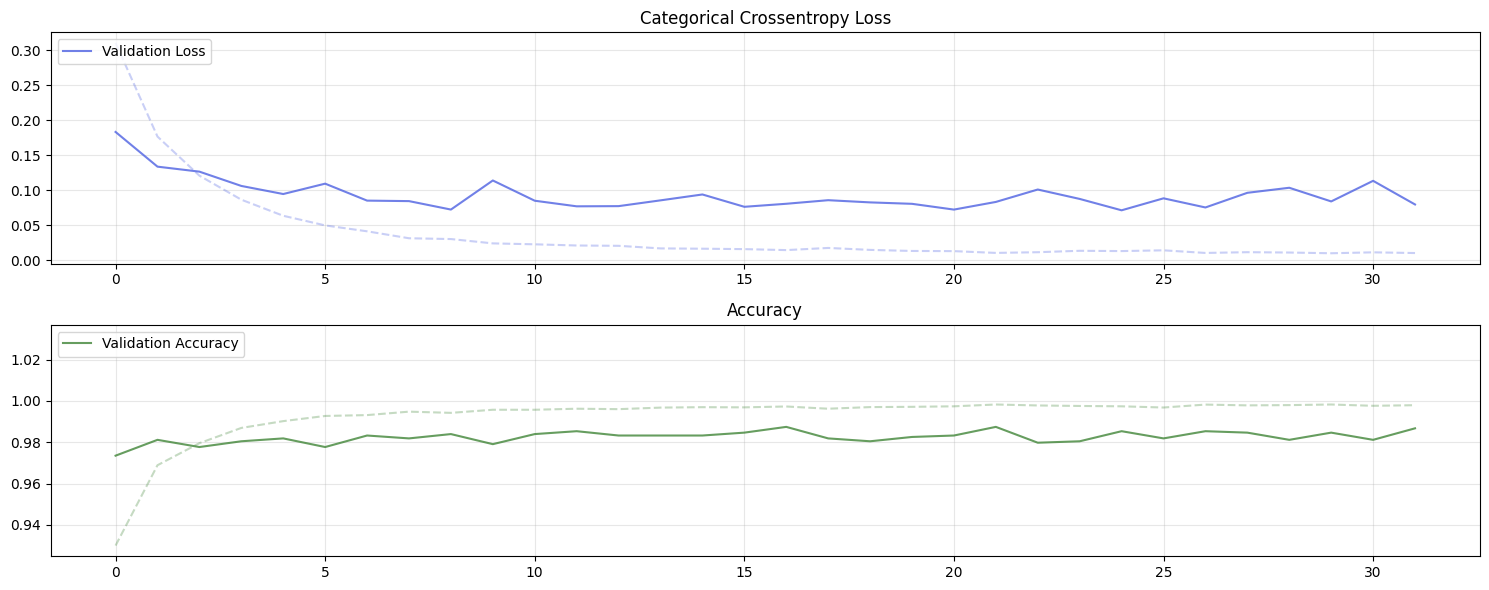

In [24]:
# Plotting Training and Fine-Tuning Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine-Tuning stages
ax1.plot(fine_tune_history.history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(fine_tune_history.history['val_loss'], label='Validation Loss', alpha=0.8, color='#4D61E2')
ax1.set_title('Categorical Crossentropy Loss')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine-Tuning stages
ax2.plot(fine_tune_history.history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.set_ylim([min(fine_tune_history.history['val_accuracy']) * 0.95, max(fine_tune_history.history['val_accuracy']) * 1.05])
ax2.legend(loc='upper left')
ax2.grid(alpha=0.3)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Preprocessing validation set for EfficientNetV2S
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step
test_prediction: [2 0 6 ... 6 3 3]
test_gt: [2 0 6 ... 6 3 3]
Accuracy score over the test set: 0.9875
Precision score over the test set: 0.9875
Recall score over the test set: 0.9875
F1 score over the test set: 0.9875
68/68 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step
ROC AUC score over the test set: 0.9985


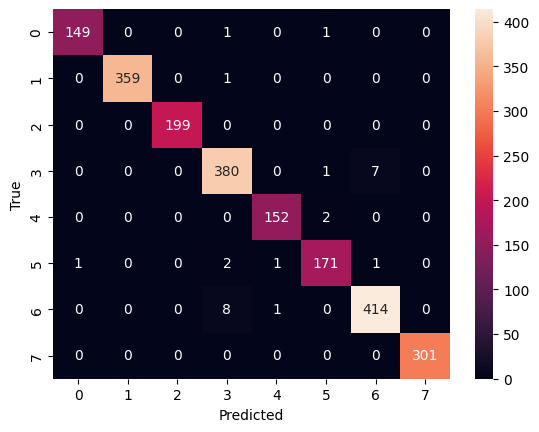

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

print(f"Preprocessing validation set for EfficientNetV2S")
if np.max(X_test) > 1:
    X_test = X_test / 255
else:
    X_test = X_test 
    
# Test the model and print the test accuracy
test_predictions = fine_tune_model.predict(X_test, verbose=1)
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = y_test.flatten()
print(f"test_prediction: {test_predictions}")
print(f"test_gt: {test_gt}")

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate recall
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate F1 score
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

try:
    test_roc_auc = roc_auc_score(y_test, fine_tune_model.predict(X_test), multi_class='ovr', average='weighted')
    print(f'ROC AUC score over the test set: {round(test_roc_auc, 4)}')
except ValueError as e:
    print(f"ROC AUC score could not be calculated: {e}")


# Calculate and plot the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X
        at X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = X/255
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [27]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 7%)
